<a href="https://colab.research.google.com/github/TanzimRusho/covid_19_data_viz/blob/main/corona_population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
glob.glob('/content/drive/My Drive/corona/data_population/*')

['/content/drive/My Drive/corona/data_population/countries_by_population_2019.csv',
 '/content/drive/My Drive/corona/data_population/covid_19_data.csv',
 '/content/drive/My Drive/corona/data_population/time_series_covid_19_recovered.csv',
 '/content/drive/My Drive/corona/data_population/time_series_covid_19_deaths.csv',
 '/content/drive/My Drive/corona/data_population/time_series_covid_19_confirmed (1).csv',
 '/content/drive/My Drive/corona/data_population/country_codes_2020.csv',
 '/content/drive/My Drive/corona/data_population/COVID19_line_list_data (1).csv']

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
df = pd.read_csv('/content/drive/My Drive/corona/data_population/covid_19_data.csv', parse_dates=['Last Update'])
df.rename(columns={'Country/Region':'Country'}, inplace=True)
df = df.drop(columns = ['SNo', "Last Update"])

countries = pd.read_csv('/content/drive/My Drive/corona/data_population/countries_by_population_2019.csv')
countries_iso = pd.read_csv('/content/drive/My Drive/corona/data_population/country_codes_2020.csv')

In [ ]:
df[df.Country == "Bangladesh"].sort_values(['ObservationDate'], ascending = False)

,ObservationDate,Province/State,Country,Confirmed,Deaths,Recovered
6070,03/16/2020,NaN,Bangladesh,8.0,0.0,2.0
5816,03/15/2020,NaN,Bangladesh,5.0,0.0,0.0
5572,03/14/2020,NaN,Bangladesh,3.0,0.0,0.0
5224,03/13/2020,NaN,Bangladesh,3.0,0.0,0.0
5098,03/12/2020,NaN,Bangladesh,3.0,0.0,0.0
4877,03/11/2020,NaN,Bangladesh,3.0,0.0,0.0
4658,03/10/2020,NaN,Bangladesh,3.0,0.0,0.0
4385,03/09/2020,NaN,Bangladesh,3.0,0.0,0.0
4126,03/08/2020,NaN,Bangladesh,3.0,0.0,0.0


In [ ]:
#fill missing Province/State with Country
df.loc[df['Province/State'].isnull(), 'Province/State'] = df.loc[df['Province/State'].isnull(), 'Country']

#keep most recent line per Province/State and Country
df.sort_values(['Country', 'Province/State', 'ObservationDate'], ascending = [True,True,False], inplace = True)
df = df.drop_duplicates(['Country', 'Province/State'], keep = "first")
df = df.drop(columns = "ObservationDate")

#groupby Country
df_country = df.groupby(['Country'], as_index=False)['Confirmed', 'Deaths'].sum()

df_country.sample(10)

,Country,Confirmed,Deaths
140,Singapore,243.0,0.0
86,Kuwait,123.0,0.0
20,Bosnia and Herzegovina,25.0,0.0
131,Rwanda,5.0,0.0
19,Bolivia,11.0,0.0
45,Equatorial Guinea,1.0,0.0
118,Panama,55.0,1.0
166,Uzbekistan,6.0,0.0
39,Cyprus,33.0,0.0
36,Croatia,57.0,0.0


In [ ]:
#drop some columns
cols_to_drop = ['Rank', 'pop2018','GrowthRate', 'area', 'Density']
countries = countries.drop(columns = cols_to_drop)

#add ISO Alpha 3 code that I uploaded in another CSV
countries = countries.merge(countries_iso[['name', 'cca3']], on = ['name'], how = "left")

cols_to_rename = {'name': 'Country', 'pop2019': 'Population', 'cca3': 'ISO'}
countries = countries.rename(columns = cols_to_rename)

countries.head()

,Country,Population,ISO
0,China,1433783.686,CHN
1,India,1366417.754,IND
2,United States,329064.917,USA
3,Indonesia,270625.568,IDN
4,Pakistan,216565.318,PAK


In [ ]:
#just fixing the most important mismatches
countries_to_rename = {'US': 'United States', 'Mainland China': 'China', 'UK': 'United Kingdom'}
df_country['Country'] = df_country['Country'].replace(countries_to_rename)

df_country = df_country.merge(countries[['Country', 'Population', 'ISO']], on = "Country", how = "left")

#check mismatches
#df_country[df_country.ISO.isnull()].sort_values(['Confirmed'], ascending = False)

#dropping not matching countries
df_country = df_country.dropna()

#rounding population to millions with 2 digits, and creating two new columns
df_country['Population'] = round((df_country['Population']/1000),2)
df_country = df_country.rename(columns = {'Population': 'Population (million)'})
df_country['Cases per Million'] = round((df_country['Confirmed']/df_country['Population (million)']),2)
df_country['Deaths per Million'] = round((df_country['Deaths']/df_country['Population (million)']),2)

#filter out small countries (less than million inhabitants)
df_country = df_country[df_country['Population (million)'] > 1]

df_country.sample(10)

,Country,Confirmed,Deaths,Population (million),ISO,Cases per Million,Deaths per Million
113,Norway,1333.0,3.0,5.38,NOR,247.77,0.56
127,Republic of the Congo,1.0,0.0,5.38,COG,0.19,0.00
55,Germany,7277.0,17.0,83.52,DEU,87.13,0.20
163,Ukraine,7.0,1.0,43.99,UKR,0.16,0.02
86,Kuwait,123.0,0.0,4.21,KWT,29.22,0.00
169,Vietnam,61.0,0.0,96.46,VNM,0.63,0.00
158,Trinidad and Tobago,4.0,0.0,1.39,TTO,2.88,0.00
137,Senegal,24.0,0.0,16.30,SEN,1.47,0.00
2,Afghanistan,21.0,0.0,38.04,AFG,0.55,0.00
76,Israel,256.0,0.0,8.52,ISR,30.05,0.00


In [ ]:
# for shap dcp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = df_country

y = data['Confirmed']

feature_names = ['Deaths',	'Population (million)',	'Cases per Million',	'Deaths per Million']

X = data[feature_names]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [ ]:
train_y

58       331.0
143        1.0
78         1.0
76       256.0
64         1.0
87        34.0
82        17.0
15        36.0
157        1.0
44       150.0
118       55.0
53         1.0
26         4.0
169       61.0
39        33.0
50       277.0
79        10.0
54        33.0
107        1.0
129      158.0
136      118.0
55      7277.0
83        10.0
94     80867.0
127        1.0
32        54.0
46       205.0
161     2007.0
168       17.0
8         52.0
145     8236.0
21       200.0
146     9942.0
56         6.0
75       169.0
37         4.0
62         2.0
35        35.0
138       55.0
163        7.0
131        5.0
72       134.0
29         1.0
102       23.0
7         56.0
155      147.0
42        11.0
165        8.0
69        39.0
130       90.0
13       214.0
117       22.0
84         3.0
2         21.0
158        4.0
80       825.0
31       155.0
86       123.0
88       100.0
12        15.0
164       98.0
19        11.0
122      177.0
137       24.0
123      331.0
99         1.0
151     11

In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394146 sha256=e39c4890a8be784ac1ab4cb2ae425de165ef5e6f9778d8e6ec39816b9b7da509
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


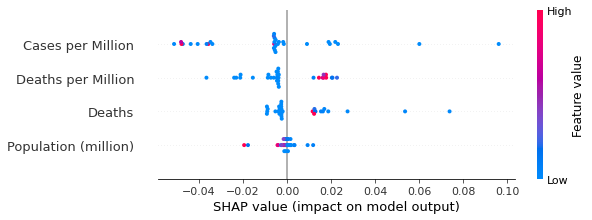

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model, check_additivity=False)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X, check_additivity=False)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

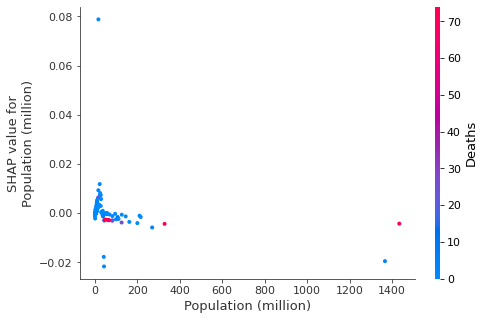

In [ ]:
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X, check_additivity=False)

# make plot.
shap.dependence_plot('Population (million)', shap_values[1], X, interaction_index="Deaths")

In [ ]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 69kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=a97349ac452ecc3fbf1d2fba0f7bf057224bff4caca8df45b4e2b1eaf23d7bc3
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


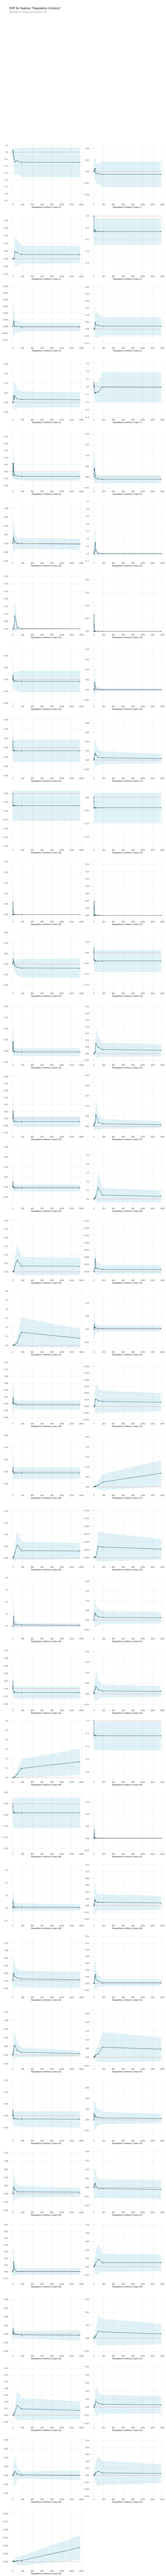

In [ ]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# make the data that we will plot
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=feature_names, feature='Population (million)')

# plot it
pdp.pdp_plot(pdp_goals, 'Population (million)')
plt.show()